In [14]:
from compare_wandb import load_attention_msa_runs
import numpy as np
from tqdm import tqdm
from pathlib import Path
import wandb

from mogwai.parsing import read_contacts
from mogwai.metrics import precisions_in_range
import torch
import seaborn as sns
import pandas as pd
from mogwai.utils.functional import apc

api = wandb.Api()


In [5]:
dict_df = load_attention_msa_runs(['transformer'])
df = dict_df['transformer']

100%|██████████| 748/748 [00:00<00:00, 33602.95it/s]

zd8rc6j7 has 748 runs


In [6]:
df.shape

(643, 16)

In [7]:
#  # download satt predicted contacts from wandb. takes several minutes
# entity = 'proteins'
# project = 'gremlin-contacts'
# pred_filename = 'predicted_contacts.npy'
# for index, row in tqdm(df.iterrows()):
#     run_id = row["run_id"]
#     pdb = row["pdb"]
#     run = api.run(f'{entity}/{project}/{run_id}')
#     downpath = Path(f'./wandb_download/{entity}/{run_id}')
#     downpath.mkdir(parents=True, exist_ok=True)
#     run.file(pred_filename).download(downpath, replace=True)

643it [07:16,  1.47it/s]


In [22]:
metrics_keys = ['short_auc', 'short_pr_at_l', 'short_pr_at_l_2', 'short_pr_at_l_5', 'short_pr_at_l_10', 'medium_auc', 'medium_pr_at_l', 'medium_pr_at_l_2', 'medium_pr_at_l_5', 'medium_pr_at_l_10', 'long_auc', 'long_pr_at_l', 'long_pr_at_l_2', 'long_pr_at_l_5', 'long_pr_at_l_10']

In [23]:
# compute precisions

rows = []
model = 'transformer'
pred_filename = 'predicted_contacts.npy'
for index, row in tqdm(df.iterrows()):
    metrics = {}
    run_id = row["run_id"]
    pdb = row["pdb"]
    metrics['pdb'] = pdb
    run = api.run(f'{entity}/{project}/{run_id}')
    downpath = Path(f'./wandb_download/{entity}/{run_id}')
    npz_filename = f'data/npz/{pdb}.npz'
    targets = torch.from_numpy(read_contacts(npz_filename))
    with open(downpath / pred_filename, 'rb') as f:
        # do apc
        predictions = apc(torch.from_numpy(np.load(f)))
        short = precisions_in_range(predictions, targets, minsep=6, maxsep=12)
        for k, v in short.items():
            metrics[f'short_{k}'] = float(v.squeeze())
        medium = precisions_in_range(predictions, targets, minsep=12, maxsep=24)
        for k, v in medium.items():
            metrics[f'medium_{k}'] = float(v.squeeze())
        long = precisions_in_range(predictions, targets, minsep=24)
        for k, v in long.items():
            metrics[f'long_{k}'] = float(v.squeeze())
    rows.append(metrics)

643it [00:03, 201.59it/s]


In [24]:

new_metrics_df = pd.DataFrame.from_records(rows)

In [25]:
merged_df = df.merge(new_metrics_df, on='pdb')

(0.0, 1.0)

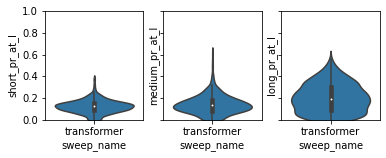

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 6/3), ncols=3, nrows=1, sharey=True)
sns.violinplot(x='sweep_name', y='short_pr_at_l', data=merged_df, ax=ax[0])
sns.violinplot(x='sweep_name', y='medium_pr_at_l', data=merged_df, ax=ax[1])
sns.violinplot(x='sweep_name', y='long_pr_at_l', data=merged_df, ax=ax[2])
plt.ylim([0, 1])

(0.0, 1.0)

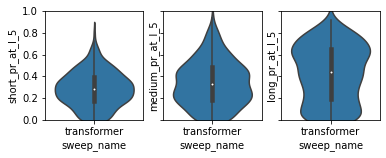

In [27]:
fig, ax = plt.subplots(figsize=(6, 6/3), ncols=3, nrows=1, sharey=True)
sns.violinplot(x='sweep_name', y='short_pr_at_l_5', data=merged_df, ax=ax[0])
sns.violinplot(x='sweep_name', y='medium_pr_at_l_5', data=merged_df, ax=ax[1])
sns.violinplot(x='sweep_name', y='long_pr_at_l_5', data=merged_df, ax=ax[2])
plt.ylim([0, 1])

In [28]:
import pickle as pkl
with open('transformer_stratified_metrics_df.pkl', 'wb') as f:
    pkl.dump(merged_df, f)

In [21]:
merged_df.keys()


Index(['sweep_name', 'pdb', 'pdb_idx', 'msa_length', 'num_seqs', 'run_state',
       'pr_at_L', 'pr_at_L_apc', 'pr_at_L_5', 'pr_at_L_5_apc', 'auc',
       'auc_apc', 'run_id', 'log_num_seqs', 'model', 'use_bias', 'short_auc',
       'short_pr_at_l', 'short_pr_at_l_2', 'short_pr_at_l_5',
       'short_pr_at_l_10', 'medium_auc', 'medium_pr_at_l', 'medium_pr_at_l_2',
       'medium_pr_at_l_5', 'medium_pr_at_l_10', 'long_auc', 'long_pr_at_l',
       'long_pr_at_l_2', 'long_pr_at_l_5', 'long_pr_at_l_10'],
      dtype='object')